# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory  = directory
        self.imgs = glob(directory + '*' + extension)
        self.transforms = transforms
        

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.imgs)
        
    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        
        # TODO: return the index-element of the dataset
        img = self.transforms(Image.open(self.imgs[index]))
        return img

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

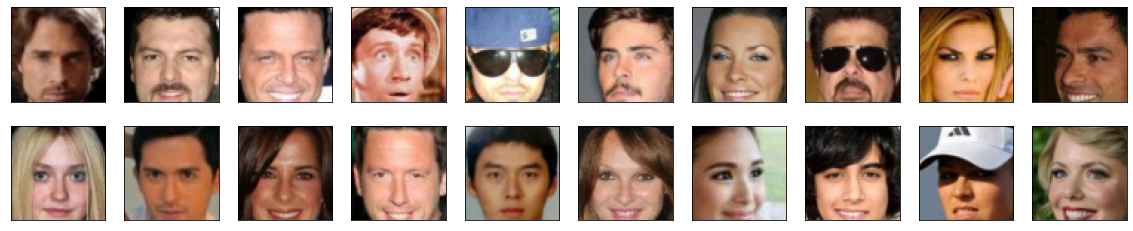

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
import torch.nn as nn

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        # complete init function
        conv_dim = conv_dim = 64
        self.conv1 = ConvBlock(3, conv_dim, 4, 2 , 1, batch_norm=False) # first layer, no batch_norm
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4, 2, 1, batch_norm=True)
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4, 2, 1, batch_norm=True)
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4, 2, 1, batch_norm=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(conv_dim*4*4*4*2, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(self.flatten(x))
        x = x.view(-1,1,1,1)
        return x

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [12]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        # TODO: instantiate the different layers
        super(Generator, self).__init__()
        conv_dim = 64
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*8, 4, 1, 0) 
        self.deconv2 = DeconvBlock(conv_dim*8, conv_dim*4, 4, 2, 1) 
        self.deconv3 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1) 
        self.deconv4 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1) 
        self.deconv5 = nn.ConvTranspose2d(in_channels = conv_dim, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, bias = False) 
        self.last_activation = nn.Tanh()
        
        
    def forward(self, x):
        # TODO: implement the forward method
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.last_activation(x)
        return x

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim
def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    lr = 0.0002
    beta1=0.5
    beta2=0.999 # default value
    # Create optimizers for the discriminator and generator
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [26]:
def generator_loss(fake_logits, smooth  = True):
    """ Generator loss, takes the fake scores as inputs. """
    """ Generator loss, takes the fake scores as inputs. """
    # Implement the generator loss 
    ## Real losses
    batch_size = fake_logits.size(0)
    if smooth:     
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    labels = labels.to(device)   
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(fake_logits.squeeze(), labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [25]:
def discriminator_loss(real_logits, fake_logits, smooth = True):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # Implement the discriminator loss 
    
    ## Real losses
    batch_size = real_logits.size(0)
    
    if smooth:    
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    real_loss = criterion(real_logits.squeeze(), labels)
    
    ## Fake losses
    batch_size_f = fake_logits.size(0)   
    labels_f = torch.zeros(batch_size_f).to(device)        
    fake_loss = criterion(fake_logits.squeeze(), labels_f)
    
    loss = real_loss + fake_loss
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    fake_images = generator(z)
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake) # use real loss to flip labels
    g_loss.backward()
    g_optimizer.step()
        
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    D_real = discriminator(real_images)
    
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    fake_images = generator(z)

    D_fake = discriminator(fake_images.detach())
    
    d_loss = discriminator_loss(D_real,D_fake) 
    d_loss.backward()
    d_optimizer.step()
    gp = 0
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [19]:
from datetime import datetime

In [20]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 30

# number of images in each batch
batch_size = 64

In [27]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-04-23 18:15:04 | Epoch [1/30] | Batch 0/509 | d_loss: 2.4178 | g_loss: 0.6613
2023-04-23 18:15:15 | Epoch [1/30] | Batch 50/509 | d_loss: 0.5765 | g_loss: 6.6016
2023-04-23 18:15:27 | Epoch [1/30] | Batch 100/509 | d_loss: 0.6277 | g_loss: 4.9413
2023-04-23 18:15:38 | Epoch [1/30] | Batch 150/509 | d_loss: 0.5195 | g_loss: 4.6948
2023-04-23 18:15:50 | Epoch [1/30] | Batch 200/509 | d_loss: 0.5784 | g_loss: 3.3981
2023-04-23 18:16:01 | Epoch [1/30] | Batch 250/509 | d_loss: 0.6247 | g_loss: 3.6366
2023-04-23 18:16:13 | Epoch [1/30] | Batch 300/509 | d_loss: 0.6719 | g_loss: 3.8913
2023-04-23 18:16:24 | Epoch [1/30] | Batch 350/509 | d_loss: 0.7511 | g_loss: 5.3506
2023-04-23 18:16:36 | Epoch [1/30] | Batch 400/509 | d_loss: 0.6651 | g_loss: 2.4274
2023-04-23 18:16:47 | Epoch [1/30] | Batch 450/509 | d_loss: 0.5834 | g_loss: 4.4589
2023-04-23 18:16:59 | Epoch [1/30] | Batch 500/509 | d_loss: 0.9582 | g_loss: 3.3625


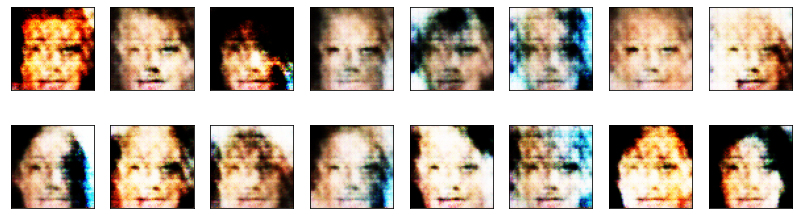

2023-04-23 18:17:02 | Epoch [2/30] | Batch 0/509 | d_loss: 1.1135 | g_loss: 2.0248
2023-04-23 18:17:13 | Epoch [2/30] | Batch 50/509 | d_loss: 0.6087 | g_loss: 3.8875
2023-04-23 18:17:25 | Epoch [2/30] | Batch 100/509 | d_loss: 0.6156 | g_loss: 4.6003
2023-04-23 18:17:36 | Epoch [2/30] | Batch 150/509 | d_loss: 0.4992 | g_loss: 4.5644
2023-04-23 18:17:48 | Epoch [2/30] | Batch 200/509 | d_loss: 0.6485 | g_loss: 3.5736
2023-04-23 18:17:59 | Epoch [2/30] | Batch 250/509 | d_loss: 0.6643 | g_loss: 2.8493
2023-04-23 18:18:11 | Epoch [2/30] | Batch 300/509 | d_loss: 1.1173 | g_loss: 7.4585
2023-04-23 18:18:22 | Epoch [2/30] | Batch 350/509 | d_loss: 0.7993 | g_loss: 2.3922
2023-04-23 18:18:33 | Epoch [2/30] | Batch 400/509 | d_loss: 0.6128 | g_loss: 3.0464
2023-04-23 18:18:45 | Epoch [2/30] | Batch 450/509 | d_loss: 0.5683 | g_loss: 5.0241
2023-04-23 18:18:56 | Epoch [2/30] | Batch 500/509 | d_loss: 0.6761 | g_loss: 2.9118


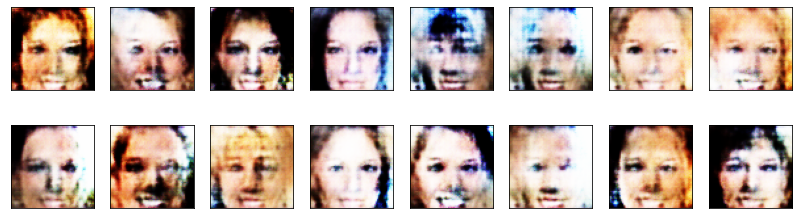

2023-04-23 18:18:59 | Epoch [3/30] | Batch 0/509 | d_loss: 0.5799 | g_loss: 3.5217
2023-04-23 18:19:11 | Epoch [3/30] | Batch 50/509 | d_loss: 0.8076 | g_loss: 2.3428
2023-04-23 18:19:22 | Epoch [3/30] | Batch 100/509 | d_loss: 0.5129 | g_loss: 3.5425
2023-04-23 18:19:34 | Epoch [3/30] | Batch 150/509 | d_loss: 0.6927 | g_loss: 2.5361
2023-04-23 18:19:45 | Epoch [3/30] | Batch 200/509 | d_loss: 0.5123 | g_loss: 3.2297
2023-04-23 18:19:57 | Epoch [3/30] | Batch 250/509 | d_loss: 0.5459 | g_loss: 3.4317
2023-04-23 18:20:08 | Epoch [3/30] | Batch 300/509 | d_loss: 0.7271 | g_loss: 3.0831
2023-04-23 18:20:19 | Epoch [3/30] | Batch 350/509 | d_loss: 0.7295 | g_loss: 2.5390
2023-04-23 18:20:31 | Epoch [3/30] | Batch 400/509 | d_loss: 0.6342 | g_loss: 2.6273
2023-04-23 18:20:42 | Epoch [3/30] | Batch 450/509 | d_loss: 0.6428 | g_loss: 3.3180
2023-04-23 18:20:54 | Epoch [3/30] | Batch 500/509 | d_loss: 0.5936 | g_loss: 2.4038


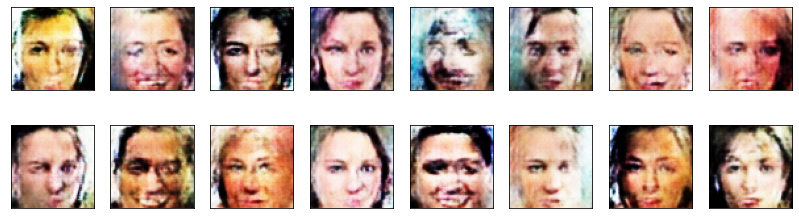

2023-04-23 18:20:57 | Epoch [4/30] | Batch 0/509 | d_loss: 0.8097 | g_loss: 1.8691
2023-04-23 18:21:08 | Epoch [4/30] | Batch 50/509 | d_loss: 0.8657 | g_loss: 4.3645
2023-04-23 18:21:20 | Epoch [4/30] | Batch 100/509 | d_loss: 0.5856 | g_loss: 3.2520
2023-04-23 18:21:31 | Epoch [4/30] | Batch 150/509 | d_loss: 0.5088 | g_loss: 2.5332
2023-04-23 18:21:43 | Epoch [4/30] | Batch 200/509 | d_loss: 0.9579 | g_loss: 2.2590
2023-04-23 18:21:54 | Epoch [4/30] | Batch 250/509 | d_loss: 0.6855 | g_loss: 2.7746
2023-04-23 18:22:05 | Epoch [4/30] | Batch 300/509 | d_loss: 0.4866 | g_loss: 3.6295
2023-04-23 18:22:17 | Epoch [4/30] | Batch 350/509 | d_loss: 0.8101 | g_loss: 1.8508
2023-04-23 18:22:28 | Epoch [4/30] | Batch 400/509 | d_loss: 0.5397 | g_loss: 3.0694
2023-04-23 18:22:40 | Epoch [4/30] | Batch 450/509 | d_loss: 0.4383 | g_loss: 4.4595
2023-04-23 18:22:51 | Epoch [4/30] | Batch 500/509 | d_loss: 0.7306 | g_loss: 2.9348


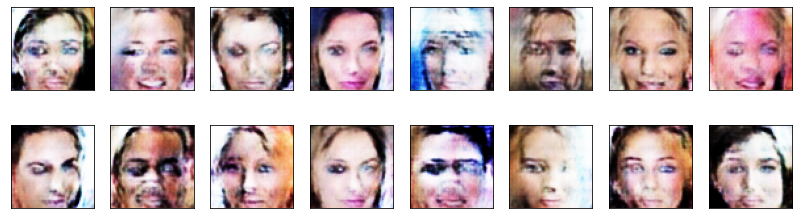

2023-04-23 18:22:54 | Epoch [5/30] | Batch 0/509 | d_loss: 0.7289 | g_loss: 2.5790
2023-04-23 18:23:06 | Epoch [5/30] | Batch 50/509 | d_loss: 0.4254 | g_loss: 3.8849
2023-04-23 18:23:17 | Epoch [5/30] | Batch 100/509 | d_loss: 0.5464 | g_loss: 3.5035
2023-04-23 18:23:29 | Epoch [5/30] | Batch 150/509 | d_loss: 0.5802 | g_loss: 2.2455
2023-04-23 18:23:40 | Epoch [5/30] | Batch 200/509 | d_loss: 0.8790 | g_loss: 5.2475
2023-04-23 18:23:52 | Epoch [5/30] | Batch 250/509 | d_loss: 0.5366 | g_loss: 2.5462
2023-04-23 18:24:03 | Epoch [5/30] | Batch 300/509 | d_loss: 0.5523 | g_loss: 2.8932
2023-04-23 18:24:14 | Epoch [5/30] | Batch 350/509 | d_loss: 0.6969 | g_loss: 3.5042
2023-04-23 18:24:26 | Epoch [5/30] | Batch 400/509 | d_loss: 0.6220 | g_loss: 3.6667
2023-04-23 18:24:37 | Epoch [5/30] | Batch 450/509 | d_loss: 0.6851 | g_loss: 2.1318
2023-04-23 18:24:49 | Epoch [5/30] | Batch 500/509 | d_loss: 0.8363 | g_loss: 1.9939


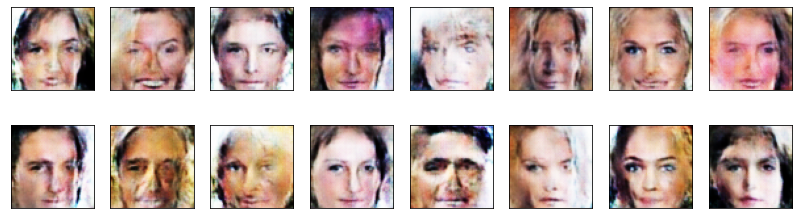

2023-04-23 18:24:52 | Epoch [6/30] | Batch 0/509 | d_loss: 0.6816 | g_loss: 3.8548
2023-04-23 18:25:03 | Epoch [6/30] | Batch 50/509 | d_loss: 0.6910 | g_loss: 2.8852
2023-04-23 18:25:15 | Epoch [6/30] | Batch 100/509 | d_loss: 0.5160 | g_loss: 3.4844
2023-04-23 18:25:26 | Epoch [6/30] | Batch 150/509 | d_loss: 0.5426 | g_loss: 4.3949
2023-04-23 18:25:38 | Epoch [6/30] | Batch 200/509 | d_loss: 2.0530 | g_loss: 7.5800
2023-04-23 18:25:49 | Epoch [6/30] | Batch 250/509 | d_loss: 0.6546 | g_loss: 2.2858
2023-04-23 18:26:00 | Epoch [6/30] | Batch 300/509 | d_loss: 1.2611 | g_loss: 5.5743
2023-04-23 18:26:12 | Epoch [6/30] | Batch 350/509 | d_loss: 0.7448 | g_loss: 2.0937
2023-04-23 18:26:23 | Epoch [6/30] | Batch 400/509 | d_loss: 0.7997 | g_loss: 1.5979
2023-04-23 18:26:35 | Epoch [6/30] | Batch 450/509 | d_loss: 1.6787 | g_loss: 6.8709
2023-04-23 18:26:46 | Epoch [6/30] | Batch 500/509 | d_loss: 0.5504 | g_loss: 3.4200


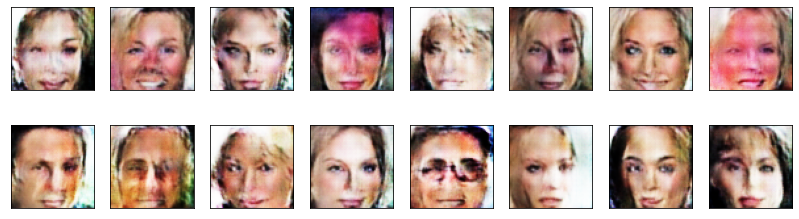

2023-04-23 18:26:49 | Epoch [7/30] | Batch 0/509 | d_loss: 0.6365 | g_loss: 5.0510
2023-04-23 18:27:01 | Epoch [7/30] | Batch 50/509 | d_loss: 0.9760 | g_loss: 1.9602
2023-04-23 18:27:12 | Epoch [7/30] | Batch 100/509 | d_loss: 1.2066 | g_loss: 5.4207
2023-04-23 18:27:23 | Epoch [7/30] | Batch 150/509 | d_loss: 0.7820 | g_loss: 5.6628
2023-04-23 18:27:35 | Epoch [7/30] | Batch 200/509 | d_loss: 0.6249 | g_loss: 3.0400
2023-04-23 18:27:46 | Epoch [7/30] | Batch 250/509 | d_loss: 0.4537 | g_loss: 3.2572
2023-04-23 18:27:58 | Epoch [7/30] | Batch 300/509 | d_loss: 0.5552 | g_loss: 2.8388
2023-04-23 18:28:09 | Epoch [7/30] | Batch 350/509 | d_loss: 0.7146 | g_loss: 3.0910
2023-04-23 18:28:21 | Epoch [7/30] | Batch 400/509 | d_loss: 0.5357 | g_loss: 3.1343
2023-04-23 18:28:32 | Epoch [7/30] | Batch 450/509 | d_loss: 1.0854 | g_loss: 5.4841
2023-04-23 18:28:43 | Epoch [7/30] | Batch 500/509 | d_loss: 0.4800 | g_loss: 1.7730


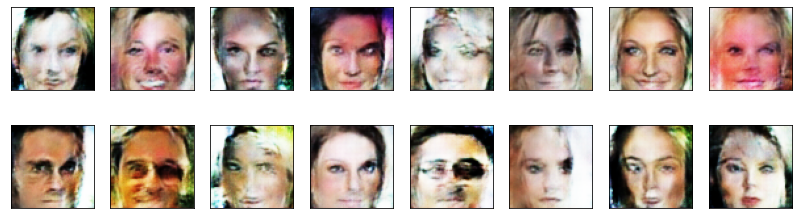

2023-04-23 18:28:47 | Epoch [8/30] | Batch 0/509 | d_loss: 0.5192 | g_loss: 2.8183
2023-04-23 18:28:58 | Epoch [8/30] | Batch 50/509 | d_loss: 0.6262 | g_loss: 4.1992
2023-04-23 18:29:09 | Epoch [8/30] | Batch 100/509 | d_loss: 0.8234 | g_loss: 2.8801
2023-04-23 18:29:21 | Epoch [8/30] | Batch 150/509 | d_loss: 0.3524 | g_loss: 3.7284
2023-04-23 18:29:32 | Epoch [8/30] | Batch 200/509 | d_loss: 1.6820 | g_loss: 6.2837
2023-04-23 18:29:44 | Epoch [8/30] | Batch 250/509 | d_loss: 0.5136 | g_loss: 3.1518
2023-04-23 18:29:55 | Epoch [8/30] | Batch 300/509 | d_loss: 0.4362 | g_loss: 4.6220
2023-04-23 18:30:07 | Epoch [8/30] | Batch 350/509 | d_loss: 0.3731 | g_loss: 2.8665
2023-04-23 18:30:18 | Epoch [8/30] | Batch 400/509 | d_loss: 0.8705 | g_loss: 5.2355
2023-04-23 18:30:29 | Epoch [8/30] | Batch 450/509 | d_loss: 0.5827 | g_loss: 4.3433
2023-04-23 18:30:41 | Epoch [8/30] | Batch 500/509 | d_loss: 0.3568 | g_loss: 3.3337


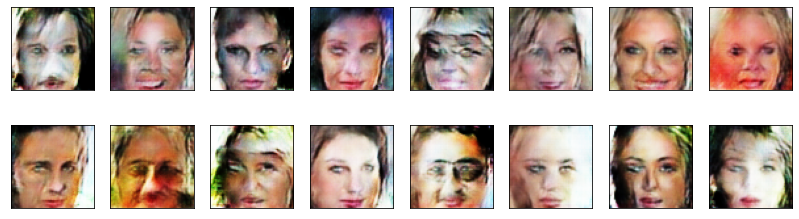

2023-04-23 18:30:44 | Epoch [9/30] | Batch 0/509 | d_loss: 0.4789 | g_loss: 5.8204
2023-04-23 18:30:55 | Epoch [9/30] | Batch 50/509 | d_loss: 0.9664 | g_loss: 2.4127
2023-04-23 18:31:07 | Epoch [9/30] | Batch 100/509 | d_loss: 0.5657 | g_loss: 4.9810
2023-04-23 18:31:18 | Epoch [9/30] | Batch 150/509 | d_loss: 1.0341 | g_loss: 5.8482
2023-04-23 18:31:30 | Epoch [9/30] | Batch 200/509 | d_loss: 0.4172 | g_loss: 2.2116
2023-04-23 18:31:41 | Epoch [9/30] | Batch 250/509 | d_loss: 0.4223 | g_loss: 3.5787
2023-04-23 18:31:53 | Epoch [9/30] | Batch 300/509 | d_loss: 0.3562 | g_loss: 3.9021
2023-04-23 18:32:04 | Epoch [9/30] | Batch 350/509 | d_loss: 0.6009 | g_loss: 3.9162
2023-04-23 18:32:15 | Epoch [9/30] | Batch 400/509 | d_loss: 0.5485 | g_loss: 4.1259
2023-04-23 18:32:27 | Epoch [9/30] | Batch 450/509 | d_loss: 1.4513 | g_loss: 3.9060
2023-04-23 18:32:38 | Epoch [9/30] | Batch 500/509 | d_loss: 0.3908 | g_loss: 4.5474


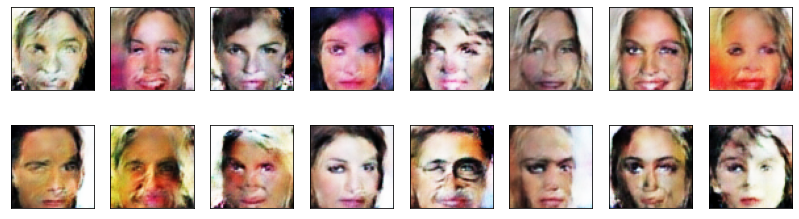

2023-04-23 18:32:41 | Epoch [10/30] | Batch 0/509 | d_loss: 0.3865 | g_loss: 3.8001
2023-04-23 18:32:53 | Epoch [10/30] | Batch 50/509 | d_loss: 1.1556 | g_loss: 2.4692
2023-04-23 18:33:04 | Epoch [10/30] | Batch 100/509 | d_loss: 0.3841 | g_loss: 6.2209
2023-04-23 18:33:16 | Epoch [10/30] | Batch 150/509 | d_loss: 0.3936 | g_loss: 3.4895
2023-04-23 18:33:27 | Epoch [10/30] | Batch 200/509 | d_loss: 0.3504 | g_loss: 6.6994
2023-04-23 18:33:39 | Epoch [10/30] | Batch 250/509 | d_loss: 0.3482 | g_loss: 6.1063
2023-04-23 18:33:50 | Epoch [10/30] | Batch 300/509 | d_loss: 0.9309 | g_loss: 5.6296
2023-04-23 18:34:01 | Epoch [10/30] | Batch 350/509 | d_loss: 0.6017 | g_loss: 2.2244
2023-04-23 18:34:13 | Epoch [10/30] | Batch 400/509 | d_loss: 0.3629 | g_loss: 3.2252
2023-04-23 18:34:24 | Epoch [10/30] | Batch 450/509 | d_loss: 0.5909 | g_loss: 3.5128
2023-04-23 18:34:36 | Epoch [10/30] | Batch 500/509 | d_loss: 0.3548 | g_loss: 6.2772


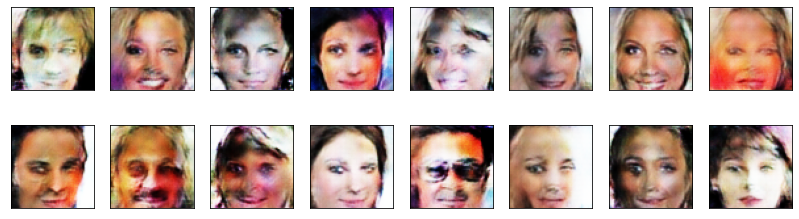

2023-04-23 18:34:39 | Epoch [11/30] | Batch 0/509 | d_loss: 0.3933 | g_loss: 3.7852
2023-04-23 18:34:50 | Epoch [11/30] | Batch 50/509 | d_loss: 0.5741 | g_loss: 3.7371
2023-04-23 18:35:02 | Epoch [11/30] | Batch 100/509 | d_loss: 0.3950 | g_loss: 2.7156
2023-04-23 18:35:13 | Epoch [11/30] | Batch 150/509 | d_loss: 0.3605 | g_loss: 7.9902
2023-04-23 18:35:25 | Epoch [11/30] | Batch 200/509 | d_loss: 0.4259 | g_loss: 2.7129
2023-04-23 18:35:36 | Epoch [11/30] | Batch 250/509 | d_loss: 0.7725 | g_loss: 4.2583
2023-04-23 18:35:47 | Epoch [11/30] | Batch 300/509 | d_loss: 0.3540 | g_loss: 5.4494
2023-04-23 18:35:59 | Epoch [11/30] | Batch 350/509 | d_loss: 0.4451 | g_loss: 5.9267
2023-04-23 18:36:10 | Epoch [11/30] | Batch 400/509 | d_loss: 0.4883 | g_loss: 4.0218
2023-04-23 18:36:22 | Epoch [11/30] | Batch 450/509 | d_loss: 0.4073 | g_loss: 5.4060
2023-04-23 18:36:33 | Epoch [11/30] | Batch 500/509 | d_loss: 0.3691 | g_loss: 7.4800


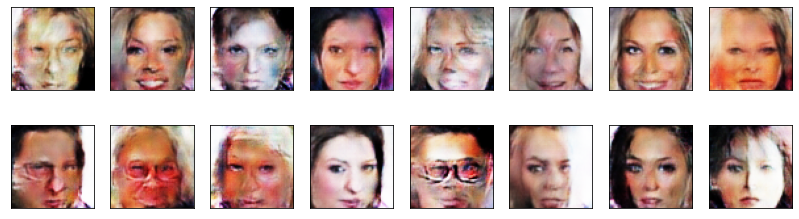

2023-04-23 18:36:36 | Epoch [12/30] | Batch 0/509 | d_loss: 0.5998 | g_loss: 4.2167
2023-04-23 18:36:48 | Epoch [12/30] | Batch 50/509 | d_loss: 0.4497 | g_loss: 4.0335
2023-04-23 18:36:59 | Epoch [12/30] | Batch 100/509 | d_loss: 0.4527 | g_loss: 4.9002
2023-04-23 18:37:11 | Epoch [12/30] | Batch 150/509 | d_loss: 0.3906 | g_loss: 4.0955
2023-04-23 18:37:22 | Epoch [12/30] | Batch 200/509 | d_loss: 1.7765 | g_loss: 0.8930
2023-04-23 18:37:33 | Epoch [12/30] | Batch 250/509 | d_loss: 0.4591 | g_loss: 3.5599
2023-04-23 18:37:45 | Epoch [12/30] | Batch 300/509 | d_loss: 0.4992 | g_loss: 5.3080
2023-04-23 18:37:56 | Epoch [12/30] | Batch 350/509 | d_loss: 0.7116 | g_loss: 4.2206
2023-04-23 18:38:08 | Epoch [12/30] | Batch 400/509 | d_loss: 0.5804 | g_loss: 4.8377
2023-04-23 18:38:19 | Epoch [12/30] | Batch 450/509 | d_loss: 0.3794 | g_loss: 4.7737
2023-04-23 18:38:30 | Epoch [12/30] | Batch 500/509 | d_loss: 2.1439 | g_loss: 0.3665


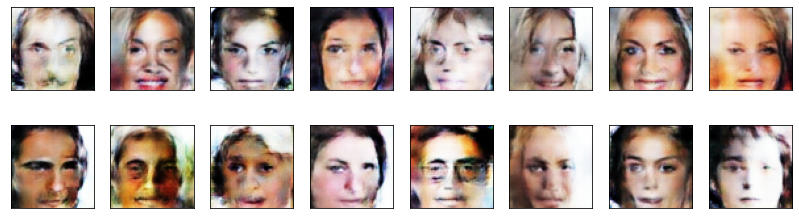

2023-04-23 18:38:34 | Epoch [13/30] | Batch 0/509 | d_loss: 0.4591 | g_loss: 5.0231
2023-04-23 18:38:45 | Epoch [13/30] | Batch 50/509 | d_loss: 0.4284 | g_loss: 5.7724
2023-04-23 18:38:56 | Epoch [13/30] | Batch 100/509 | d_loss: 0.4601 | g_loss: 4.9271
2023-04-23 18:39:08 | Epoch [13/30] | Batch 150/509 | d_loss: 0.5016 | g_loss: 2.3380
2023-04-23 18:39:19 | Epoch [13/30] | Batch 200/509 | d_loss: 0.3583 | g_loss: 7.0281
2023-04-23 18:39:31 | Epoch [13/30] | Batch 250/509 | d_loss: 0.5400 | g_loss: 4.7953
2023-04-23 18:39:42 | Epoch [13/30] | Batch 300/509 | d_loss: 0.4005 | g_loss: 3.3908
2023-04-23 18:39:54 | Epoch [13/30] | Batch 350/509 | d_loss: 0.4535 | g_loss: 5.0558
2023-04-23 18:40:05 | Epoch [13/30] | Batch 400/509 | d_loss: 0.3827 | g_loss: 4.8266
2023-04-23 18:40:16 | Epoch [13/30] | Batch 450/509 | d_loss: 0.3423 | g_loss: 4.3061
2023-04-23 18:40:28 | Epoch [13/30] | Batch 500/509 | d_loss: 0.4912 | g_loss: 4.1595


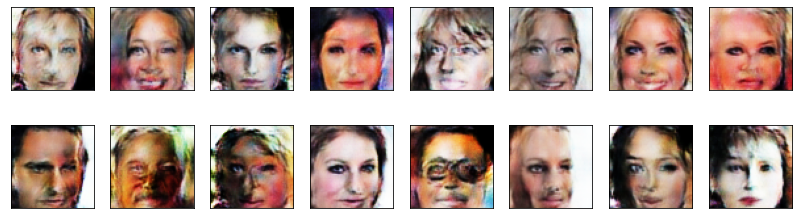

2023-04-23 18:40:31 | Epoch [14/30] | Batch 0/509 | d_loss: 0.3651 | g_loss: 3.2857
2023-04-23 18:40:42 | Epoch [14/30] | Batch 50/509 | d_loss: 0.4836 | g_loss: 2.4525
2023-04-23 18:40:54 | Epoch [14/30] | Batch 100/509 | d_loss: 0.8618 | g_loss: 3.4182
2023-04-23 18:41:05 | Epoch [14/30] | Batch 150/509 | d_loss: 0.3908 | g_loss: 3.9182
2023-04-23 18:41:17 | Epoch [14/30] | Batch 200/509 | d_loss: 0.3876 | g_loss: 6.1549
2023-04-23 18:41:28 | Epoch [14/30] | Batch 250/509 | d_loss: 0.4704 | g_loss: 4.2159
2023-04-23 18:41:39 | Epoch [14/30] | Batch 300/509 | d_loss: 0.4722 | g_loss: 4.7711
2023-04-23 18:41:51 | Epoch [14/30] | Batch 350/509 | d_loss: 0.4010 | g_loss: 3.4405
2023-04-23 18:42:02 | Epoch [14/30] | Batch 400/509 | d_loss: 0.4242 | g_loss: 4.0598
2023-04-23 18:42:14 | Epoch [14/30] | Batch 450/509 | d_loss: 0.4129 | g_loss: 5.1838
2023-04-23 18:42:25 | Epoch [14/30] | Batch 500/509 | d_loss: 0.5998 | g_loss: 3.5498


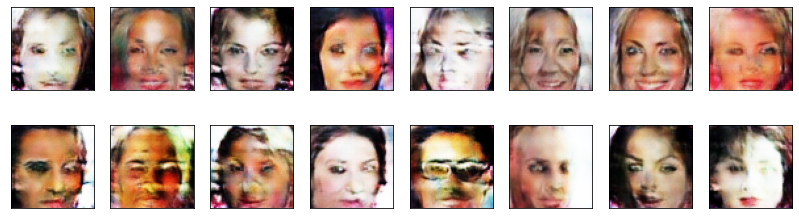

2023-04-23 18:42:28 | Epoch [15/30] | Batch 0/509 | d_loss: 0.4171 | g_loss: 5.3499
2023-04-23 18:42:40 | Epoch [15/30] | Batch 50/509 | d_loss: 0.4355 | g_loss: 3.2396
2023-04-23 18:42:51 | Epoch [15/30] | Batch 100/509 | d_loss: 0.3618 | g_loss: 3.7272
2023-04-23 18:43:02 | Epoch [15/30] | Batch 150/509 | d_loss: 0.4121 | g_loss: 5.0808
2023-04-23 18:43:14 | Epoch [15/30] | Batch 200/509 | d_loss: 0.5716 | g_loss: 5.0183
2023-04-23 18:43:25 | Epoch [15/30] | Batch 250/509 | d_loss: 0.3945 | g_loss: 6.3532
2023-04-23 18:43:37 | Epoch [15/30] | Batch 300/509 | d_loss: 0.3745 | g_loss: 3.5717
2023-04-23 18:43:48 | Epoch [15/30] | Batch 350/509 | d_loss: 0.4669 | g_loss: 2.7803
2023-04-23 18:44:00 | Epoch [15/30] | Batch 400/509 | d_loss: 0.3833 | g_loss: 3.2380
2023-04-23 18:44:11 | Epoch [15/30] | Batch 450/509 | d_loss: 0.4233 | g_loss: 5.1003
2023-04-23 18:44:22 | Epoch [15/30] | Batch 500/509 | d_loss: 0.3692 | g_loss: 4.0197


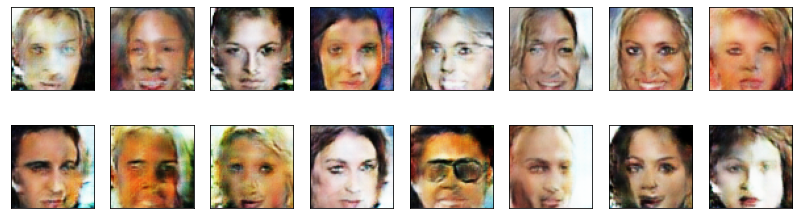

2023-04-23 18:44:26 | Epoch [16/30] | Batch 0/509 | d_loss: 0.6320 | g_loss: 2.7620
2023-04-23 18:44:37 | Epoch [16/30] | Batch 50/509 | d_loss: 0.6025 | g_loss: 4.9649
2023-04-23 18:44:48 | Epoch [16/30] | Batch 100/509 | d_loss: 0.4648 | g_loss: 6.0677
2023-04-23 18:45:00 | Epoch [16/30] | Batch 150/509 | d_loss: 0.5257 | g_loss: 4.6403
2023-04-23 18:45:11 | Epoch [16/30] | Batch 200/509 | d_loss: 0.4265 | g_loss: 3.8648
2023-04-23 18:45:23 | Epoch [16/30] | Batch 250/509 | d_loss: 0.3792 | g_loss: 3.0340
2023-04-23 18:45:34 | Epoch [16/30] | Batch 300/509 | d_loss: 0.4224 | g_loss: 3.3266
2023-04-23 18:45:46 | Epoch [16/30] | Batch 350/509 | d_loss: 0.4403 | g_loss: 5.9324
2023-04-23 18:45:57 | Epoch [16/30] | Batch 400/509 | d_loss: 0.7019 | g_loss: 3.3558
2023-04-23 18:46:08 | Epoch [16/30] | Batch 450/509 | d_loss: 0.4461 | g_loss: 3.5815
2023-04-23 18:46:20 | Epoch [16/30] | Batch 500/509 | d_loss: 0.3972 | g_loss: 4.0737


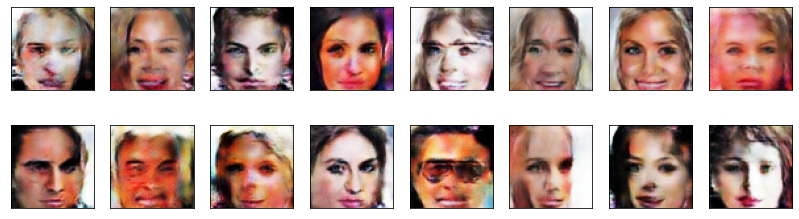

2023-04-23 18:46:23 | Epoch [17/30] | Batch 0/509 | d_loss: 0.3614 | g_loss: 2.7588
2023-04-23 18:46:34 | Epoch [17/30] | Batch 50/509 | d_loss: 0.3724 | g_loss: 5.0867
2023-04-23 18:46:46 | Epoch [17/30] | Batch 100/509 | d_loss: 0.8594 | g_loss: 2.9611
2023-04-23 18:46:57 | Epoch [17/30] | Batch 150/509 | d_loss: 0.4585 | g_loss: 3.2703
2023-04-23 18:47:09 | Epoch [17/30] | Batch 200/509 | d_loss: 0.4163 | g_loss: 3.8307
2023-04-23 18:47:20 | Epoch [17/30] | Batch 250/509 | d_loss: 0.4205 | g_loss: 3.4358
2023-04-23 18:47:31 | Epoch [17/30] | Batch 300/509 | d_loss: 0.4024 | g_loss: 3.1955
2023-04-23 18:47:43 | Epoch [17/30] | Batch 350/509 | d_loss: 0.4160 | g_loss: 3.7382
2023-04-23 18:47:54 | Epoch [17/30] | Batch 400/509 | d_loss: 0.3609 | g_loss: 4.4141
2023-04-23 18:48:06 | Epoch [17/30] | Batch 450/509 | d_loss: 0.3479 | g_loss: 4.4795
2023-04-23 18:48:17 | Epoch [17/30] | Batch 500/509 | d_loss: 0.4496 | g_loss: 3.7943


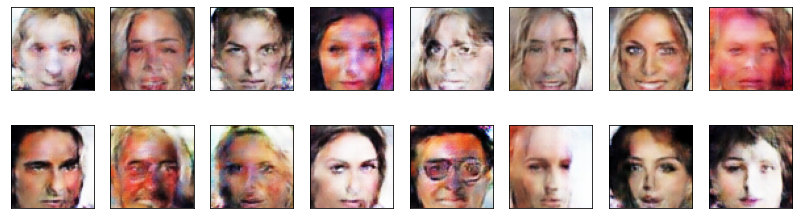

2023-04-23 18:48:20 | Epoch [18/30] | Batch 0/509 | d_loss: 0.4688 | g_loss: 3.6033
2023-04-23 18:48:32 | Epoch [18/30] | Batch 50/509 | d_loss: 0.5277 | g_loss: 3.1794
2023-04-23 18:48:43 | Epoch [18/30] | Batch 100/509 | d_loss: 0.4933 | g_loss: 2.6948
2023-04-23 18:48:55 | Epoch [18/30] | Batch 150/509 | d_loss: 0.5398 | g_loss: 2.8146
2023-04-23 18:49:06 | Epoch [18/30] | Batch 200/509 | d_loss: 0.5882 | g_loss: 3.8877
2023-04-23 18:49:18 | Epoch [18/30] | Batch 250/509 | d_loss: 0.3688 | g_loss: 3.8865
2023-04-23 18:49:29 | Epoch [18/30] | Batch 300/509 | d_loss: 0.3716 | g_loss: 5.1216
2023-04-23 18:49:40 | Epoch [18/30] | Batch 350/509 | d_loss: 0.3616 | g_loss: 3.7594
2023-04-23 18:49:52 | Epoch [18/30] | Batch 400/509 | d_loss: 0.3579 | g_loss: 3.4430
2023-04-23 18:50:03 | Epoch [18/30] | Batch 450/509 | d_loss: 0.4765 | g_loss: 4.8240
2023-04-23 18:50:15 | Epoch [18/30] | Batch 500/509 | d_loss: 0.4096 | g_loss: 4.5003


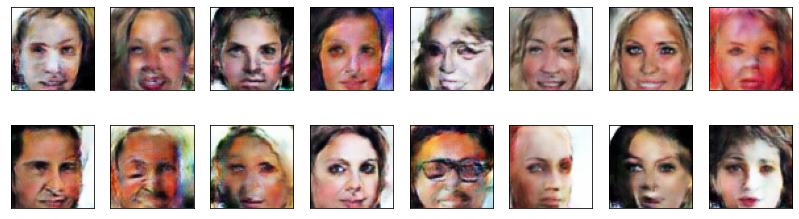

2023-04-23 18:50:18 | Epoch [19/30] | Batch 0/509 | d_loss: 0.5685 | g_loss: 4.4291
2023-04-23 18:50:29 | Epoch [19/30] | Batch 50/509 | d_loss: 0.4135 | g_loss: 4.3526
2023-04-23 18:50:41 | Epoch [19/30] | Batch 100/509 | d_loss: 0.4295 | g_loss: 6.0308
2023-04-23 18:50:52 | Epoch [19/30] | Batch 150/509 | d_loss: 0.4628 | g_loss: 2.3597
2023-04-23 18:51:03 | Epoch [19/30] | Batch 200/509 | d_loss: 0.4700 | g_loss: 3.9915
2023-04-23 18:51:15 | Epoch [19/30] | Batch 250/509 | d_loss: 0.5714 | g_loss: 4.6181
2023-04-23 18:51:26 | Epoch [19/30] | Batch 300/509 | d_loss: 0.4924 | g_loss: 4.5972
2023-04-23 18:51:38 | Epoch [19/30] | Batch 350/509 | d_loss: 0.8601 | g_loss: 5.7912
2023-04-23 18:51:49 | Epoch [19/30] | Batch 400/509 | d_loss: 0.6297 | g_loss: 3.0771
2023-04-23 18:52:00 | Epoch [19/30] | Batch 450/509 | d_loss: 0.5120 | g_loss: 4.0561
2023-04-23 18:52:12 | Epoch [19/30] | Batch 500/509 | d_loss: 0.3702 | g_loss: 3.8732


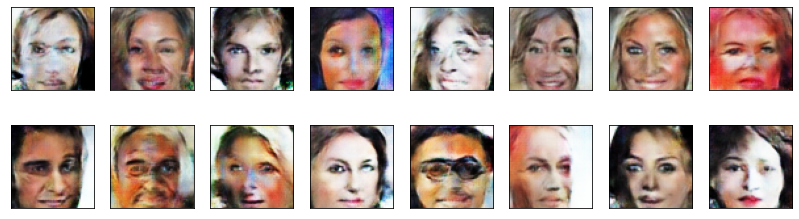

2023-04-23 18:52:15 | Epoch [20/30] | Batch 0/509 | d_loss: 0.4063 | g_loss: 4.3494
2023-04-23 18:52:26 | Epoch [20/30] | Batch 50/509 | d_loss: 0.4207 | g_loss: 4.4393
2023-04-23 18:52:38 | Epoch [20/30] | Batch 100/509 | d_loss: 0.4408 | g_loss: 4.6328
2023-04-23 18:52:49 | Epoch [20/30] | Batch 150/509 | d_loss: 0.4939 | g_loss: 4.7490
2023-04-23 18:53:01 | Epoch [20/30] | Batch 200/509 | d_loss: 0.3746 | g_loss: 4.8251
2023-04-23 18:53:12 | Epoch [20/30] | Batch 250/509 | d_loss: 0.3762 | g_loss: 3.7474
2023-04-23 18:53:23 | Epoch [20/30] | Batch 300/509 | d_loss: 0.3660 | g_loss: 4.3552
2023-04-23 18:53:35 | Epoch [20/30] | Batch 350/509 | d_loss: 0.3842 | g_loss: 4.3064
2023-04-23 18:53:46 | Epoch [20/30] | Batch 400/509 | d_loss: 0.6600 | g_loss: 3.8047
2023-04-23 18:53:58 | Epoch [20/30] | Batch 450/509 | d_loss: 0.4152 | g_loss: 3.9386
2023-04-23 18:54:09 | Epoch [20/30] | Batch 500/509 | d_loss: 0.3632 | g_loss: 4.1588


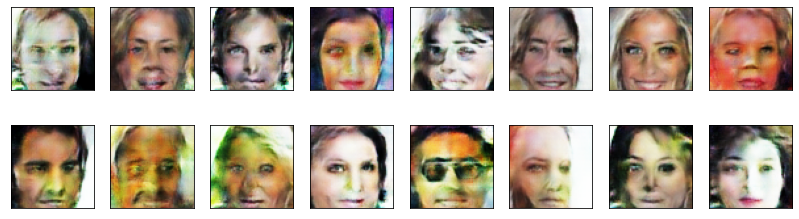

2023-04-23 18:54:12 | Epoch [21/30] | Batch 0/509 | d_loss: 0.3479 | g_loss: 4.7263
2023-04-23 18:54:24 | Epoch [21/30] | Batch 50/509 | d_loss: 0.4455 | g_loss: 4.2656
2023-04-23 18:54:35 | Epoch [21/30] | Batch 100/509 | d_loss: 0.5975 | g_loss: 4.4083
2023-04-23 18:54:46 | Epoch [21/30] | Batch 150/509 | d_loss: 0.3814 | g_loss: 3.8655
2023-04-23 18:54:58 | Epoch [21/30] | Batch 200/509 | d_loss: 0.3612 | g_loss: 2.9035
2023-04-23 18:55:09 | Epoch [21/30] | Batch 250/509 | d_loss: 0.4122 | g_loss: 3.9116
2023-04-23 18:55:21 | Epoch [21/30] | Batch 300/509 | d_loss: 0.3625 | g_loss: 2.9182
2023-04-23 18:55:32 | Epoch [21/30] | Batch 350/509 | d_loss: 0.4031 | g_loss: 4.9959
2023-04-23 18:55:43 | Epoch [21/30] | Batch 400/509 | d_loss: 0.4160 | g_loss: 4.1437
2023-04-23 18:55:55 | Epoch [21/30] | Batch 450/509 | d_loss: 0.3867 | g_loss: 3.5157
2023-04-23 18:56:06 | Epoch [21/30] | Batch 500/509 | d_loss: 0.3621 | g_loss: 3.3110


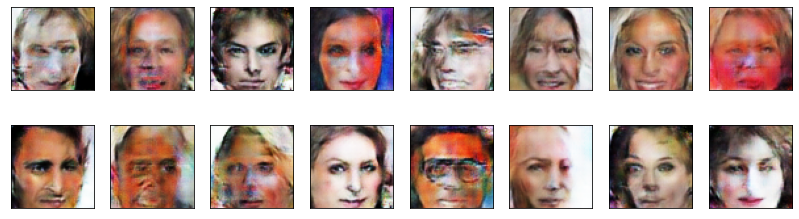

2023-04-23 18:56:10 | Epoch [22/30] | Batch 0/509 | d_loss: 0.3569 | g_loss: 5.9344
2023-04-23 18:56:21 | Epoch [22/30] | Batch 50/509 | d_loss: 0.3782 | g_loss: 4.7765
2023-04-23 18:56:32 | Epoch [22/30] | Batch 100/509 | d_loss: 0.3563 | g_loss: 4.1861
2023-04-23 18:56:44 | Epoch [22/30] | Batch 150/509 | d_loss: 4.5065 | g_loss: 11.2007
2023-04-23 18:56:55 | Epoch [22/30] | Batch 200/509 | d_loss: 0.4479 | g_loss: 3.4131
2023-04-23 18:57:07 | Epoch [22/30] | Batch 250/509 | d_loss: 0.3992 | g_loss: 2.0524
2023-04-23 18:57:18 | Epoch [22/30] | Batch 300/509 | d_loss: 0.3966 | g_loss: 5.0004
2023-04-23 18:57:29 | Epoch [22/30] | Batch 350/509 | d_loss: 0.4631 | g_loss: 3.0209
2023-04-23 18:57:41 | Epoch [22/30] | Batch 400/509 | d_loss: 0.4229 | g_loss: 5.6004
2023-04-23 18:57:52 | Epoch [22/30] | Batch 450/509 | d_loss: 0.5494 | g_loss: 3.6768
2023-04-23 18:58:04 | Epoch [22/30] | Batch 500/509 | d_loss: 1.0412 | g_loss: 6.7153


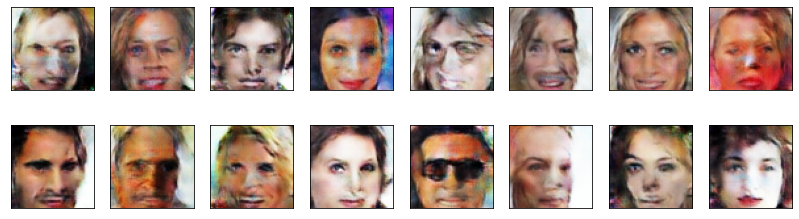

2023-04-23 18:58:07 | Epoch [23/30] | Batch 0/509 | d_loss: 0.4532 | g_loss: 3.7484
2023-04-23 18:58:18 | Epoch [23/30] | Batch 50/509 | d_loss: 0.3699 | g_loss: 3.5687
2023-04-23 18:58:30 | Epoch [23/30] | Batch 100/509 | d_loss: 0.3739 | g_loss: 3.5293
2023-04-23 18:58:41 | Epoch [23/30] | Batch 150/509 | d_loss: 0.5340 | g_loss: 4.2678
2023-04-23 18:58:52 | Epoch [23/30] | Batch 200/509 | d_loss: 0.3654 | g_loss: 3.3251
2023-04-23 18:59:04 | Epoch [23/30] | Batch 250/509 | d_loss: 0.5534 | g_loss: 2.0930
2023-04-23 18:59:15 | Epoch [23/30] | Batch 300/509 | d_loss: 0.4583 | g_loss: 3.5549
2023-04-23 18:59:27 | Epoch [23/30] | Batch 350/509 | d_loss: 0.3905 | g_loss: 4.3462
2023-04-23 18:59:38 | Epoch [23/30] | Batch 400/509 | d_loss: 0.8790 | g_loss: 6.0506
2023-04-23 18:59:50 | Epoch [23/30] | Batch 450/509 | d_loss: 0.5160 | g_loss: 5.5533
2023-04-23 19:00:01 | Epoch [23/30] | Batch 500/509 | d_loss: 0.4129 | g_loss: 4.0207


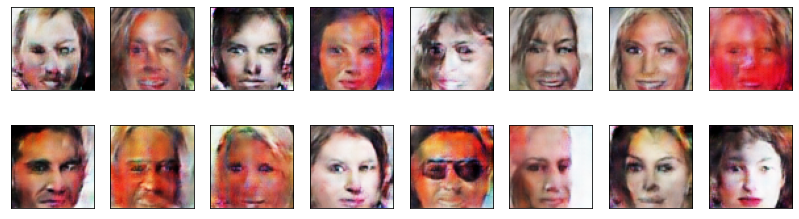

2023-04-23 19:00:04 | Epoch [24/30] | Batch 0/509 | d_loss: 0.4500 | g_loss: 5.1493
2023-04-23 19:00:16 | Epoch [24/30] | Batch 50/509 | d_loss: 0.3635 | g_loss: 4.3189
2023-04-23 19:00:27 | Epoch [24/30] | Batch 100/509 | d_loss: 0.4191 | g_loss: 5.2024
2023-04-23 19:00:38 | Epoch [24/30] | Batch 150/509 | d_loss: 0.3568 | g_loss: 5.0475
2023-04-23 19:00:50 | Epoch [24/30] | Batch 200/509 | d_loss: 0.3946 | g_loss: 5.1459
2023-04-23 19:01:01 | Epoch [24/30] | Batch 250/509 | d_loss: 0.6206 | g_loss: 2.8455
2023-04-23 19:01:13 | Epoch [24/30] | Batch 300/509 | d_loss: 0.4633 | g_loss: 3.7076
2023-04-23 19:01:24 | Epoch [24/30] | Batch 350/509 | d_loss: 0.6222 | g_loss: 4.4515
2023-04-23 19:01:36 | Epoch [24/30] | Batch 400/509 | d_loss: 0.4718 | g_loss: 3.2700
2023-04-23 19:01:47 | Epoch [24/30] | Batch 450/509 | d_loss: 0.6164 | g_loss: 2.0011
2023-04-23 19:01:58 | Epoch [24/30] | Batch 500/509 | d_loss: 0.5953 | g_loss: 3.4133


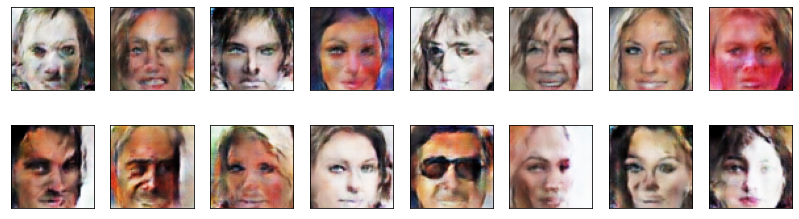

2023-04-23 19:02:01 | Epoch [25/30] | Batch 0/509 | d_loss: 0.4619 | g_loss: 3.9735
2023-04-23 19:02:13 | Epoch [25/30] | Batch 50/509 | d_loss: 0.5451 | g_loss: 2.8669
2023-04-23 19:02:24 | Epoch [25/30] | Batch 100/509 | d_loss: 0.4105 | g_loss: 4.2432
2023-04-23 19:02:36 | Epoch [25/30] | Batch 150/509 | d_loss: 0.3991 | g_loss: 3.4124
2023-04-23 19:02:47 | Epoch [25/30] | Batch 200/509 | d_loss: 0.3771 | g_loss: 5.3659
2023-04-23 19:02:59 | Epoch [25/30] | Batch 250/509 | d_loss: 0.3784 | g_loss: 4.9223
2023-04-23 19:03:10 | Epoch [25/30] | Batch 300/509 | d_loss: 0.3824 | g_loss: 4.4573
2023-04-23 19:03:21 | Epoch [25/30] | Batch 350/509 | d_loss: 0.4833 | g_loss: 3.3698
2023-04-23 19:03:33 | Epoch [25/30] | Batch 400/509 | d_loss: 0.3677 | g_loss: 5.7544
2023-04-23 19:03:44 | Epoch [25/30] | Batch 450/509 | d_loss: 0.3980 | g_loss: 5.5868
2023-04-23 19:03:56 | Epoch [25/30] | Batch 500/509 | d_loss: 0.4710 | g_loss: 5.9468


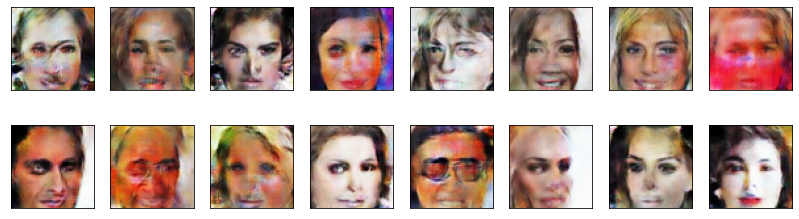

2023-04-23 19:03:59 | Epoch [26/30] | Batch 0/509 | d_loss: 0.3930 | g_loss: 4.0743
2023-04-23 19:04:10 | Epoch [26/30] | Batch 50/509 | d_loss: 0.3596 | g_loss: 7.3817
2023-04-23 19:04:22 | Epoch [26/30] | Batch 100/509 | d_loss: 0.3901 | g_loss: 5.4104
2023-04-23 19:04:33 | Epoch [26/30] | Batch 150/509 | d_loss: 0.3534 | g_loss: 4.0950
2023-04-23 19:04:44 | Epoch [26/30] | Batch 200/509 | d_loss: 0.7736 | g_loss: 1.8624
2023-04-23 19:04:56 | Epoch [26/30] | Batch 250/509 | d_loss: 0.4423 | g_loss: 3.6395
2023-04-23 19:05:07 | Epoch [26/30] | Batch 300/509 | d_loss: 0.3921 | g_loss: 4.1640
2023-04-23 19:05:19 | Epoch [26/30] | Batch 350/509 | d_loss: 0.3661 | g_loss: 4.3891
2023-04-23 19:05:30 | Epoch [26/30] | Batch 400/509 | d_loss: 0.4092 | g_loss: 3.6916
2023-04-23 19:05:41 | Epoch [26/30] | Batch 450/509 | d_loss: 0.3950 | g_loss: 3.8889
2023-04-23 19:05:53 | Epoch [26/30] | Batch 500/509 | d_loss: 0.9891 | g_loss: 1.5756


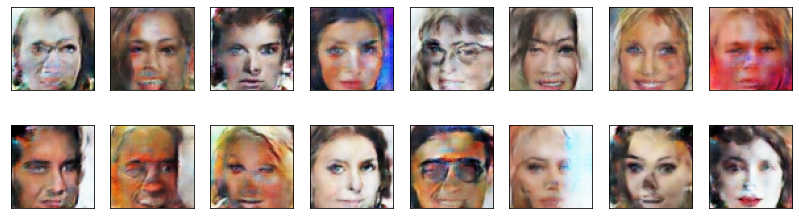

2023-04-23 19:05:56 | Epoch [27/30] | Batch 0/509 | d_loss: 0.4257 | g_loss: 4.4766
2023-04-23 19:06:08 | Epoch [27/30] | Batch 50/509 | d_loss: 0.3619 | g_loss: 3.9629
2023-04-23 19:06:19 | Epoch [27/30] | Batch 100/509 | d_loss: 0.4197 | g_loss: 4.6790
2023-04-23 19:06:30 | Epoch [27/30] | Batch 150/509 | d_loss: 0.5505 | g_loss: 2.8892
2023-04-23 19:06:42 | Epoch [27/30] | Batch 200/509 | d_loss: 0.3522 | g_loss: 4.2324
2023-04-23 19:06:53 | Epoch [27/30] | Batch 250/509 | d_loss: 0.6192 | g_loss: 3.4821
2023-04-23 19:07:05 | Epoch [27/30] | Batch 300/509 | d_loss: 0.4372 | g_loss: 4.5608
2023-04-23 19:07:16 | Epoch [27/30] | Batch 350/509 | d_loss: 0.3837 | g_loss: 4.4645
2023-04-23 19:07:27 | Epoch [27/30] | Batch 400/509 | d_loss: 0.4006 | g_loss: 6.0538
2023-04-23 19:07:39 | Epoch [27/30] | Batch 450/509 | d_loss: 0.3676 | g_loss: 4.1142
2023-04-23 19:07:50 | Epoch [27/30] | Batch 500/509 | d_loss: 0.3913 | g_loss: 4.5481


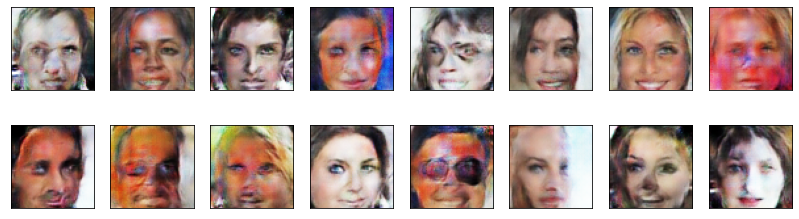

2023-04-23 19:07:53 | Epoch [28/30] | Batch 0/509 | d_loss: 0.3477 | g_loss: 3.6951
2023-04-23 19:08:05 | Epoch [28/30] | Batch 50/509 | d_loss: 0.4178 | g_loss: 3.9997
2023-04-23 19:08:16 | Epoch [28/30] | Batch 100/509 | d_loss: 0.4132 | g_loss: 3.5702
2023-04-23 19:08:28 | Epoch [28/30] | Batch 150/509 | d_loss: 0.4758 | g_loss: 3.8987
2023-04-23 19:08:39 | Epoch [28/30] | Batch 200/509 | d_loss: 0.4410 | g_loss: 4.8612
2023-04-23 19:08:51 | Epoch [28/30] | Batch 250/509 | d_loss: 0.5615 | g_loss: 2.2780
2023-04-23 19:09:02 | Epoch [28/30] | Batch 300/509 | d_loss: 0.4889 | g_loss: 3.2700
2023-04-23 19:09:13 | Epoch [28/30] | Batch 350/509 | d_loss: 0.4261 | g_loss: 3.0750
2023-04-23 19:09:25 | Epoch [28/30] | Batch 400/509 | d_loss: 0.6225 | g_loss: 3.5053
2023-04-23 19:09:36 | Epoch [28/30] | Batch 450/509 | d_loss: 0.3606 | g_loss: 3.3957
2023-04-23 19:09:48 | Epoch [28/30] | Batch 500/509 | d_loss: 0.4669 | g_loss: 4.2475


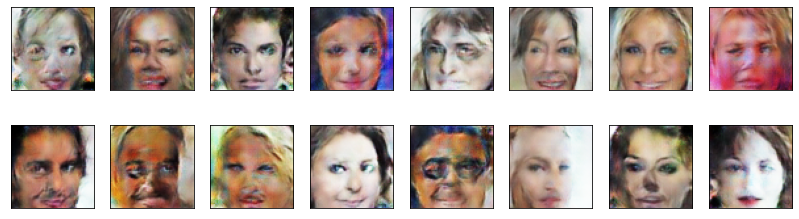

2023-04-23 19:09:51 | Epoch [29/30] | Batch 0/509 | d_loss: 0.3960 | g_loss: 3.5220
2023-04-23 19:10:02 | Epoch [29/30] | Batch 50/509 | d_loss: 0.3608 | g_loss: 3.0538
2023-04-23 19:10:14 | Epoch [29/30] | Batch 100/509 | d_loss: 0.5271 | g_loss: 4.3949
2023-04-23 19:10:25 | Epoch [29/30] | Batch 150/509 | d_loss: 0.3589 | g_loss: 3.3626
2023-04-23 19:10:37 | Epoch [29/30] | Batch 200/509 | d_loss: 0.3764 | g_loss: 4.0386
2023-04-23 19:10:48 | Epoch [29/30] | Batch 250/509 | d_loss: 0.4353 | g_loss: 3.0186
2023-04-23 19:10:59 | Epoch [29/30] | Batch 300/509 | d_loss: 0.5835 | g_loss: 2.9609
2023-04-23 19:11:11 | Epoch [29/30] | Batch 350/509 | d_loss: 0.3812 | g_loss: 4.1492
2023-04-23 19:11:22 | Epoch [29/30] | Batch 400/509 | d_loss: 0.4210 | g_loss: 4.6171
2023-04-23 19:11:34 | Epoch [29/30] | Batch 450/509 | d_loss: 1.0833 | g_loss: 1.7841
2023-04-23 19:11:45 | Epoch [29/30] | Batch 500/509 | d_loss: 0.5631 | g_loss: 2.7563


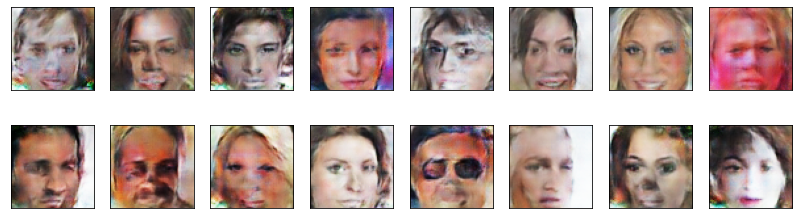

2023-04-23 19:11:48 | Epoch [30/30] | Batch 0/509 | d_loss: 0.4502 | g_loss: 4.4306
2023-04-23 19:12:00 | Epoch [30/30] | Batch 50/509 | d_loss: 0.3656 | g_loss: 4.0040
2023-04-23 19:12:11 | Epoch [30/30] | Batch 100/509 | d_loss: 0.4431 | g_loss: 4.0186
2023-04-23 19:12:22 | Epoch [30/30] | Batch 150/509 | d_loss: 0.3645 | g_loss: 4.1007
2023-04-23 19:12:34 | Epoch [30/30] | Batch 200/509 | d_loss: 0.4047 | g_loss: 4.2451
2023-04-23 19:12:45 | Epoch [30/30] | Batch 250/509 | d_loss: 0.3981 | g_loss: 3.3501
2023-04-23 19:12:57 | Epoch [30/30] | Batch 300/509 | d_loss: 0.4827 | g_loss: 5.6207
2023-04-23 19:13:08 | Epoch [30/30] | Batch 350/509 | d_loss: 0.4208 | g_loss: 3.2763
2023-04-23 19:13:19 | Epoch [30/30] | Batch 400/509 | d_loss: 0.3964 | g_loss: 4.0444
2023-04-23 19:13:31 | Epoch [30/30] | Batch 450/509 | d_loss: 0.3838 | g_loss: 4.6394
2023-04-23 19:13:42 | Epoch [30/30] | Batch 500/509 | d_loss: 0.4204 | g_loss: 4.1673


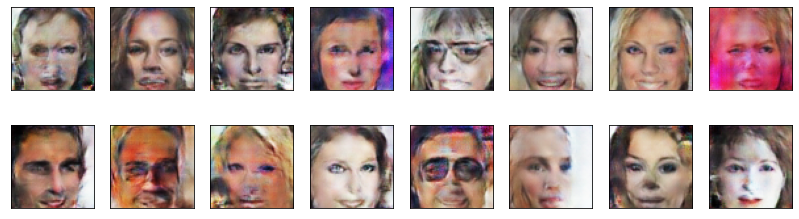

In [28]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

train_on_gpu = True
losses = []
# train the network
discriminator.train()
generator.train()

train_on_gpu = True
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # TRAIN THE GENERATOR
        g_loss = generator_step(batch_size, latent_dim)
        # TRAIN THE DISCRIMINATOR
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

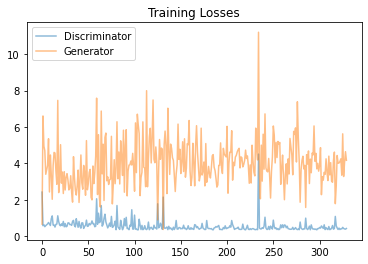

In [29]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

As I am looking at the generated samples, I can see that some of them are a bit cartoonish (a bit different from a real human face). It is possible that if I increase the number of epochs or change the hyper-parameters, the generated samples get closer and closer to the real human being faces. Also, if the training set contains human beings from different races, this could improve the overall performance of the generated samples. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.